In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from gpytorch.kernels import RBFKernel
from grakel.kernels import WeisfeilerLehman
from gpytorch.priors import NormalPrior
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.models import GIN, GAT, GCN, GraphSAGE

from mobius import Planner, SequenceGA, Pool
from mobius import ProteinEmbedding
from mobius import InverseFolding
from mobius import GPLLModel, GPModel, GPGNNModel, GPGKModel
from mobius import ExpectedImprovement
from mobius import Graph, Map4Fingerprint
from mobius import TanimotoSimilarityKernel
from mobius import homolog_scanning
from mobius import convert_FASTA_to_HELM, convert_HELM_to_FASTA
from mobius import VinaScorer
from mobius.utils import MolFromHELM


## Initialize VinaScorer as Thrombin oracle

Citation: Large Libraries of Structurally Diverse Macrocycles Suitable for Membrane Permeation; Nielsen et al.; 2023; https://doi.org/10.1002/ange.202400350

In [3]:
vs = VinaScorer(receptor_pdbqt_filename='8ase_chain_B.pdbqt', center=[-7.06, -15.335, -24.845], dimensions=[30, 30, 30])

## Run Bayesian Optimization

### Define design protocol

In [7]:
yaml_content = """design:
  monomers:
    S1: [R, 4CIF, Thio]
    BB-AA: [G, NMeA, bAla, gAla, Ac3c, Amcp, Acpc, Ac6c, 2Amb, 3Amb, 4Amb, 2Achc, 4Achc, Trx, cAcha, tAcha, dPip, Nip, dNip, Isn, P, dP, bhPro, Aze, APipAc]
    AT-AA: [Mea, A2, A3, A4, A5, A6, A7]
    linkers: ['[*]CC(=O)C[*] |$_R1;;;;;_R2$|', '[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|', '[*]C/C=C/C[*] |$_R1;;;;;_R2$|', '[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|', '[*]CC1=COC=C1(C[*]) |$_R1;;;;;;;;_R2;$|', '[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|', '[*]Cc1nc2ccccc2nc1(C[*]) |$_R1;;;;;;;;;;;;;_R2;$|']
  polymers:
    - CHEM1{X}|PEPTIDE1{[Mpa].X.X.X}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0:
        CHEM1:
          1: linkers
        PEPTIDE1:
          2: BB-AA
          3: S1
          4: AT-AA
    - CHEM1{X}|PEPTIDE1{[Mpa].X.X.X}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0:
        CHEM1:
          1: linkers
        PEPTIDE1:
          2: S1
          3: BB-AA
          4: AT-AA
    - CHEM1{X}|PEPTIDE1{[Mpa].X.X}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0:
        CHEM1:
          1: linkers
        PEPTIDE1:
          2: S1
          3: AT-AA
    """
    
with open('design_protocol.yaml', 'w') as f:
    f.write(yaml_content)

### Generate seed library

In [11]:
def generate_random_thrombin_macrocycle(n=96):
    S1 = ["R", "[4CIF]", "[Thio]"]
    BBAA = ["G", "[NMeA]", "[bAla]", "[gAla]", "[Ac3c]", "[Amcp]", "[Acpc]", "[Ac6c]", "[2Amb]", "[3Amb]", "[4Amb]", 
            "[2Achc]", "[4Achc]", "[Trx]", "[cAcha]", "[tAcha]", "[dPip]", "[Nip]", "[dNip]", "[Isn]", "P", "[dP]", "[bhPro]", 
            "[Aze]", "[APipAc]"] # "[3Aze]" "[Aib]"
    ATAA = ["[Mea]", "[A2]", "[A3]", "[A4]", "[A5]", "[A6]", "[A7]"]
    linkers = ['[*]CC(=O)C[*] |$_R1;;;;;_R2$|', '[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|', '[*]C/C=C/C[*] |$_R1;;;;;_R2$|', 
               '[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|', '[*]CC1=COC=C1(C[*]) |$_R1;;;;;;;;_R2;$|', 
               '[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|', '[*]Cc1nc2ccccc2nc1(C[*]) |$_R1;;;;;;;;;;;;;_R2;$|']
    
    scaffolds = ['CHEM1{{{linker}}}|PEPTIDE1{{[Mpa].{aa1}.{aa2}.{aa3}}}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0',
                 'CHEM1{{{linker}}}|PEPTIDE1{{[Mpa].{aa1}.{aa2}}}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0']
    
    peptide_library = []
    
    while True:
        i_scaffold = np.random.choice([0, 1, 2])
    
        linker = np.random.choice(linkers)
        
        if i_scaffold == 0:
            aa1 = np.random.choice(BBAA)
            aa2 = np.random.choice(S1)
            aa3 = np.random.choice(ATAA)
            peptide_library.append(scaffolds[0].format(linker=linker, aa1=aa1, aa2=aa2, aa3=aa3))
        if i_scaffold == 1:
            aa1 = np.random.choice(S1)
            aa2 = np.random.choice(BBAA)
            aa3 = np.random.choice(ATAA)
            peptide_library.append(scaffolds[0].format(linker=linker, aa1=aa1, aa2=aa2, aa3=aa3))
        else:
            aa1 = np.random.choice(S1)
            aa2 = np.random.choice(ATAA)
            peptide_library.append(scaffolds[1].format(linker=linker, aa1=aa1, aa2=aa2))
    
        if len(np.unique(peptide_library)) >= 96:
            break
    
    peptide_library = np.unique(peptide_library)

    return peptide_library

In [5]:
seed_library = generate_random_thrombin_macrocycle(96)

scores_seed_library = []

ref = Chem.MolFromMolFile('8ase_H_NWR.sdf')

for seq in seed_library:
    mol = MolFromHELM(seq, HELM_extra_library_filename='library.json')[0]
    mol = Chem.AddHs(mol)

    mol_docked, vina_scores = vs.dock(mol, template=ref, adjust_protonation=True, num_confs=1)
    
    if mol_docked is not None:
        scores_seed_library.append(vina_scores[0])
    else:
        scores_seed_library.append(0)

    print(seq, scores_seed_library[-1])

scores_seed_library = np.asarray(scores_seed_library)

[15:21:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].R.[A7]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0 -2.034
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].R.[Amcp].[A7]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.727
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[2Achc].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.549
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[4Achc].[A4]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -5.768
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0 -3.881
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[A6]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0 -4.272
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[Aze].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -2.724
CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[Mea]}$CHEM1,PEPTID

### MAP4 fingerprint

In [29]:
map4 = Map4Fingerprint(input_type='HELM', chiral=False, HELM_extra_library_filename='library.json')
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))

In [30]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol.yaml')
ps = Planner(acq, optimizer)

In [31]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get vina docking scores
    scores_suggested_peptides = []

    for j, seq in enumerate(suggested_peptides):
        mol = MolFromHELM(seq, HELM_extra_library_filename='library.json')[0]
        mol = Chem.AddHs(mol)
    
        mol_docked, vina_scores = vs.dock(mol, template=ref, adjust_protonation=True, num_confs=1)
        
        if mol_docked is not None:
            scores_suggested_peptides.append(vina_scores[0])
        else:
            scores_suggested_peptides.append(0)
    
        print(j, seq, scores_suggested_peptides[-1])

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4_oracle.csv', index=False)

Fitting GP model (cuda): 18step [00:00, 152.95step/s, loss=3.45]
2024-11-13 16:39:18,372	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=914549) ==========================================================================================================
(parallel_ga_gpu pid=914549) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=914549) ==========================================================================================================
(parallel_ga_gpu pid=914549)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=914549) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=914549)      2 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=914549)      3 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=914549) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=914549)   if hasattr(self, key):
(parallel_ga_gpu pid=914549) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=914549)   v = getattr(self, key)


(parallel_ga_gpu pid=914550) ==========================================================================================================
(parallel_ga_gpu pid=914550) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=914550) ==========================================================================================================
(parallel_ga_gpu pid=914550)      1 |        0 |  6.3566165818988E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=914550)      2 |      500 | -9.9728705483903E-01 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=914550)      3 |     1000 | -1.5645177976685E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=914550)      4 |     1500 | -1.9090612747075E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=914550)      5 |     2000 |

Fitting GP model (cuda): 21step [00:00, 84.15step/s, loss=2.97] 
2024-11-13 16:42:13,784	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=927699) ==========================================================================================================
(parallel_ga_gpu pid=927699) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=927699) ==========================================================================================================
(parallel_ga_gpu pid=927699)      1 |        0 |  3.2058135135135E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=927699) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=927699)      2 |      146 |  6.22396257880377668 | -1.4855287982198E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=927699)      3 |      146 |  6.22396257880377668 | -1.4855287982198E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=927699) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=927699)   if hasattr(self, key):
(parallel_ga_gpu pid=927699) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=927699)   v = getattr(self, key)


(parallel_ga_gpu pid=927700) ==========================================================================================================
(parallel_ga_gpu pid=927700) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=927700) ==========================================================================================================
(parallel_ga_gpu pid=927700)      1 |        0 |  6.3472815349922E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=927700)      2 |      500 | -4.6707895682847E-01 | -1.4286181038641E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=927700)      3 |     1000 | -7.1766140212304E-01 | -1.6325479157674E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=927700)      4 |     1500 | -8.5739540876388E-01 | -1.7299825212652E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=927700)      5 |     2000 |

Fitting GP model (cuda): 19step [00:00, 152.03step/s, loss=2.88]
2024-11-13 16:45:25,424	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=941105) ==========================================================================================================
(parallel_ga_gpu pid=941105) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=941105) ==========================================================================================================
(parallel_ga_gpu pid=941105)      1 |        0 |  3.1805200000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=941105) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=941105)      2 |      143 |  6.79598747566637851 | -1.1866767648897E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=941105)      3 |      143 |  6.79598747566637851 | -1.1866767648897E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=941105) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=941105)   if hasattr(self, key):
(parallel_ga_gpu pid=941105) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=941105)   v = getattr(self, key)


(parallel_ga_gpu pid=941106) ==========================================================================================================
(parallel_ga_gpu pid=941106) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=941106) ==========================================================================================================
(parallel_ga_gpu pid=941106)      1 |        0 |  6.3027691392728E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=941106)      2 |      500 | -2.9807192053959E-01 | -1.1011214864741E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=941106)      3 |     1000 | -4.5450118175004E-01 | -1.2021315631132E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=941106)      4 |     1500 | -5.3850034414764E-01 | -1.2021315631132E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=941106)      5 |     2000 |

Fitting GP model (cuda): 19step [00:00, 104.71step/s, loss=3.31]
2024-11-13 16:48:45,964	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=954340) ==========================================================================================================
(parallel_ga_gpu pid=954340) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=954340) ==========================================================================================================
(parallel_ga_gpu pid=954340)      1 |        0 |  3.1087312500000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=954340) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=954340)      2 |      135 |  8.00591668382602073 | -7.6924648532676E-01 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=954340)      3 |      135 |  8.00591668382602073 | -7.6924648532676E-01 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=954340) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=954340)   if hasattr(self, key):
(parallel_ga_gpu pid=954340) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=954340)   v = getattr(self, key)


(parallel_ga_gpu pid=954339) ==========================================================================================================
(parallel_ga_gpu pid=954339) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=954339) ==========================================================================================================
(parallel_ga_gpu pid=954339)      1 |        0 |  6.5982239785111E+01 |  6.0142000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=954339)      2 |      500 | -2.9545666731788E-01 | -1.1887770796076E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=954339)      3 |     1000 | -4.7136324455618E-01 | -1.2612034345601E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=954339)      4 |     1500 | -5.7218816869899E-01 | -1.2612034345601E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=954339)      5 |     2000 |

Fitting GP model (cuda): 21step [00:00, 139.41step/s, loss=3.15]
2024-11-13 16:52:08,672	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=967660) ==========================================================================================================
(parallel_ga_gpu pid=967660) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=967660) ==========================================================================================================
(parallel_ga_gpu pid=967660)      1 |        0 |  3.0929196078431E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=967660) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=967660)      2 |      132 |  8.52501063694774075 | -6.8451721060890E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=967660)      3 |      132 |  8.52501063694774075 | -6.8451721060890E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=967660) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=967660)   if hasattr(self, key):
(parallel_ga_gpu pid=967660) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=967660)   v = getattr(self, key)


(parallel_ga_gpu pid=967661) ==========================================================================================================
(parallel_ga_gpu pid=967661) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=967661) ==========================================================================================================
(parallel_ga_gpu pid=967661)      1 |        0 |  6.5666404396313E+01 |  6.0186000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=967661)      2 |      500 | -2.1158568817029E-01 | -7.6984562977977E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=967661)      3 |     1000 | -3.5432389697271E-01 | -1.0853133772636E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=967661)      4 |     1500 | -4.5270500845318E-01 | -1.2730477642906E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=967661)      5 |     2000 |

### MAP4 chiral fingerprint

In [6]:
map4 = Map4Fingerprint(input_type='HELM', chiral=True, HELM_extra_library_filename='library.json')
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))

In [8]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol.yaml')
ps = Planner(acq, optimizer)

In [9]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4C', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get vina docking scores
    scores_suggested_peptides = []

    for j, seq in enumerate(suggested_peptides):
        mol = MolFromHELM(seq, HELM_extra_library_filename='library.json')[0]
        mol = Chem.AddHs(mol)
    
        mol_docked, vina_scores = vs.dock(mol, template=ref, adjust_protonation=True, num_confs=1)
        
        if mol_docked is not None:
            scores_suggested_peptides.append(vina_scores[0])
        else:
            scores_suggested_peptides.append(0)
    
        print(j, seq, scores_suggested_peptides[-1])

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4C', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4C_oracle.csv', index=False)

Fitting GP model (cuda): 19step [00:00, 43.76step/s, loss=3.45]
2024-11-13 15:22:53,056	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=648748) ==========================================================================================================
(parallel_ga_gpu pid=648748) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=648748) ==========================================================================================================
(parallel_ga_gpu pid=648748)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=648748) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=648748)      2 |      147 |  5.81324993372690901 | -2.8447839322598E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=648748)      3 |      147 |  5.81324993372690901 | -2.8447839322598E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=648748) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=648748)   if hasattr(self, key):
(parallel_ga_gpu pid=648748) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=648748)   v = getattr(self, key)


(parallel_ga_gpu pid=648749) ==========================================================================================================
(parallel_ga_gpu pid=648749) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=648749) ==========================================================================================================
(parallel_ga_gpu pid=648749)      1 |        0 |  6.3527678452795E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=648749)      2 |      500 | -9.2107550923134E-01 | -2.9206999559693E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=648749)      3 |     1000 | -1.3297060535732E+00 | -3.3310196947826E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=648749)      4 |     1500 | -1.5566381633804E+00 | -3.4695926321299E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=648749)      5 |     2000 |

Fitting GP model (cuda): 19step [00:00, 63.79step/s, loss=3.03]
2024-11-13 15:26:58,869	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=662053) ==========================================================================================================
(parallel_ga_gpu pid=662053) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=662053) ==========================================================================================================
(parallel_ga_gpu pid=662053)      1 |        0 |  3.1595902439024E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=662053) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=662053)      2 |      142 |  6.89833288654664312 | -1.3028796024816E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=662053)      3 |      142 |  6.89833288654664312 | -1.3028796024816E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=662053) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=662053)   if hasattr(self, key):
(parallel_ga_gpu pid=662053) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=662053)   v = getattr(self, key)


(parallel_ga_gpu pid=662054) ==========================================================================================================
(parallel_ga_gpu pid=662054) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=662054) ==========================================================================================================
(parallel_ga_gpu pid=662054)      1 |        0 |  6.3534522934272E+01 |  5.7798000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=662054)      2 |      500 | -4.0805137467929E-01 | -1.1868944991274E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=662054)      3 |     1000 | -5.5469307219170E-01 | -1.1868944991274E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=662054)      4 |     1500 | -6.2237802739312E-01 | -1.1868944991274E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=662054)      5 |     2000 |

Fitting GP model (cuda): 24step [00:00, 107.98step/s, loss=3.49]
2024-11-13 15:31:42,696	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=675351) ==========================================================================================================
(parallel_ga_gpu pid=675351) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=675351) ==========================================================================================================
(parallel_ga_gpu pid=675351)      1 |        0 |  3.1328636363636E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=675351) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=675351)      2 |      139 |  7.00392769065868137 | -2.4836512532274E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=675351)      3 |      139 |  7.00392769065868137 | -2.4836512532274E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=675351) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=675351)   if hasattr(self, key):
(parallel_ga_gpu pid=675351) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=675351)   v = getattr(self, key)


(parallel_ga_gpu pid=675352) ==========================================================================================================
(parallel_ga_gpu pid=675352) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=675352) ==========================================================================================================
(parallel_ga_gpu pid=675352)      1 |        0 |  8.0568118329757E+01 |  7.4016000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=675352)      2 |      500 | -9.9984237189674E-01 | -4.2974428454932E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=675352)      3 |     1000 | -1.3784597088791E+00 | -4.2974428454932E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=675352)      4 |     1500 | -1.5562792589001E+00 | -4.2974428454932E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=675352)      5 |     2000 |

Fitting GP model (cuda): 25step [00:00, 108.58step/s, loss=3.41]
2024-11-13 15:37:10,728	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=688754) ==========================================================================================================
(parallel_ga_gpu pid=688754) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=688754) ==========================================================================================================
(parallel_ga_gpu pid=688754)      1 |        0 |  3.1252066666667E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=688754) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=688754)      2 |      138 |  7.28115915699433547 | -1.7263225704303E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=688754)      3 |      138 |  7.28115915699433547 | -1.7263225704303E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=688754) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=688754)   if hasattr(self, key):
(parallel_ga_gpu pid=688754) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=688754)   v = getattr(self, key)


(parallel_ga_gpu pid=688755) ==========================================================================================================
(parallel_ga_gpu pid=688755) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=688755) ==========================================================================================================
(parallel_ga_gpu pid=688755)      1 |        0 |  8.0414735357630E+01 |  7.4016000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=688755)      2 |      500 | -7.0503871596523E-01 | -2.3816955837367E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=688755)      3 |     1000 | -9.9411066332173E-01 | -2.3816955837367E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=688755)      4 |     1500 | -1.1272917797766E+00 | -2.3816955837367E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=688755)      5 |     2000 |

Fitting GP model (cuda): 25step [00:00, 108.54step/s, loss=3.3]
2024-11-13 15:41:52,740	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=702351) ==========================================================================================================
(parallel_ga_gpu pid=702351) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=702351) ==========================================================================================================
(parallel_ga_gpu pid=702351)      1 |        0 |  3.1014979591837E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=702351) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=702351)      2 |      134 |  8.05029879462690445 | -1.1720474385867E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=702351)      3 |      134 |  8.05029879462690445 | -1.1720474385867E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=702351) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=702351)   if hasattr(self, key):
(parallel_ga_gpu pid=702351) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=702351)   v = getattr(self, key)


(parallel_ga_gpu pid=702352) ==========================================================================================================
(parallel_ga_gpu pid=702352) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=702352) ==========================================================================================================
(parallel_ga_gpu pid=702352)      1 |        0 |  8.0181664261434E+01 |  7.4016000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=702352)      2 |      500 | -4.3099612236053E-01 | -1.2078833743122E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=702352)      3 |     1000 | -6.1717283513960E-01 | -1.2078833743122E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=702352)      4 |     1500 | -6.9768729365492E-01 | -1.3448089486137E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=702352)      5 |     2000 |

### Graph Kernel

In [26]:
graph_convertor = Graph(input_type='HELM', output_type='grakel', HELM_extra_library_filename='library.json')
kernel = WeisfeilerLehman(normalize=True, n_iter=5)
gp = GPGKModel(kernel=kernel, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

In [27]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol.yaml')
ps = Planner(acq, optimizer)

In [28]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('WL', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get vina docking scores
    scores_suggested_peptides = []

    for j, seq in enumerate(suggested_peptides):
        mol = MolFromHELM(seq, HELM_extra_library_filename='library.json')[0]
        mol = Chem.AddHs(mol)
    
        mol_docked, vina_scores = vs.dock(mol, template=ref, adjust_protonation=True, num_confs=1)
        
        if mol_docked is not None:
            scores_suggested_peptides.append(vina_scores[0])
        else:
            scores_suggested_peptides.append(0)
    
        print(j, seq, scores_suggested_peptides[-1])

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('WL', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_WL_oracle.csv', index=False)

Fitting GPGK model (cpu): 32step [00:05,  5.38step/s, loss=3.71]
2024-11-13 16:19:27,640	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=846522) ==========================================================================================================
(parallel_ga_gpu pid=846522) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=846522) ==========================================================================================================
(parallel_ga_gpu pid=846522)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=846522) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=846522)      2 |      147 |  5.53597757463624696 | -1.7607221479525E+01 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=846522)      3 |      147 |  5.53597757463624696 | -1.7607221479525E+01 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=846522) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=846522)   if hasattr(self, key):
(parallel_ga_gpu pid=846522) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=846522)   v = getattr(self, key)


(parallel_ga_gpu pid=846523) ==========================================================================================================
(parallel_ga_gpu pid=846523) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=846523) ==========================================================================================================
(parallel_ga_gpu pid=846523)      1 |        0 |  6.3778579067837E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=846523)      2 |      500 | -1.4663568553349E+00 | -8.9028850674607E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=846523)      3 |     1000 | -3.0393493992816E+00 | -1.0719739667680E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=846523)      4 |     1500 | -4.5394205332470E+00 | -1.2320407173266E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=846523)      5 |     2000 |

Fitting GPGK model (cpu): 42step [00:14,  2.89step/s, loss=6.17]
2024-11-13 16:22:31,436	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=859713) ==========================================================================================================
(parallel_ga_gpu pid=859713) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=859713) ==========================================================================================================
(parallel_ga_gpu pid=859713)      1 |        0 |  3.1988000000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=859713) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=859713)      2 |      145 |  4.60250538867028336 | -1.4219146197985E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=859713)      3 |      145 |  4.60250538867028336 | -1.4219146197985E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=859713) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=859713)   if hasattr(self, key):
(parallel_ga_gpu pid=859713) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=859713)   v = getattr(self, key)


(parallel_ga_gpu pid=859714) ==========================================================================================================
(parallel_ga_gpu pid=859714) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=859714) ==========================================================================================================
(parallel_ga_gpu pid=859714)      1 |        0 |  8.6591384136122E+01 |  7.5054000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=859714)      2 |      500 | -4.5887199305991E+00 | -2.9313179180651E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=859714)      3 |     1000 | -8.3804383514186E+00 | -4.3500909636735E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=859714)      4 |     1500 | -1.1175176332148E+01 | -4.3500909636735E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=859714)      5 |     2000 |

(parallel_ga_gpu pid=859714) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated [repeated 2x across cluster]
(parallel_ga_gpu pid=859714)   if hasattr(self, key):
(parallel_ga_gpu pid=859714)   v = getattr(self, key)


0 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[bAla].[bAla].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 2.77
1 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[bAla].[2Amb].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -0.87
2 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[bAla].[2Achc].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -2.508
3 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[bAla].[bhPro].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -2.462
4 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].G.[bhPro].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -1.699
5 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[bAla].[gAla].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 7.446
6 CHEM1{[[*]CC(=O)C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[bAla].G.[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -0.719
7 CHEM1{[[*]CC(=O)C[*] |

Fitting GPGK model (cpu): 9step [00:05,  1.69step/s, loss=6.02]
2024-11-13 16:24:59,312	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=872794) ==========================================================================================================
(parallel_ga_gpu pid=872794) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=872794) ==========================================================================================================
(parallel_ga_gpu pid=872794)      1 |        0 |  3.1988000000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=872794) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=872794)      2 |      145 |  4.67752941056187854 | -1.0628828245871E+01 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=872794)      3 |      145 |  4.67752941056187854 | -1.0628828245871E+01 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=872794) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=872794)   if hasattr(self, key):
(parallel_ga_gpu pid=872794) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=872794)   v = getattr(self, key)


(parallel_ga_gpu pid=872795) ==========================================================================================================
(parallel_ga_gpu pid=872795) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=872795) ==========================================================================================================
(parallel_ga_gpu pid=872795)      1 |        0 |  1.0137561844978E+02 |  9.0162000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=872795)      2 |      500 | -4.1013249914844E+00 | -1.8785788035688E+01 | CHEM1{[[*]CS(=O)(=....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=872795)      3 |     1000 | -7.5888903655207E+00 | -2.0935964682377E+01 | CHEM1{[[*]CS(=O)(=....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=872795)      4 |     1500 | -9.6211993348656E+00 | -2.1607466457552E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=872795)      5 |     2000 |

Fitting GPGK model (cpu): 21step [00:15,  1.35step/s, loss=5.43]
2024-11-13 16:28:47,108	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=886036) ==========================================================================================================
(parallel_ga_gpu pid=886036) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=886036) ==========================================================================================================
(parallel_ga_gpu pid=886036)      1 |        0 |  3.1988000000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=886036) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=886036)      2 |      145 |  5.42069761153144647 | -7.3767981375536E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=886036)      3 |      145 |  5.42069761153144647 | -7.3767981375536E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=886036) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=886036)   if hasattr(self, key):
(parallel_ga_gpu pid=886036) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=886036)   v = getattr(self, key)


(parallel_ga_gpu pid=886037) ==========================================================================================================
(parallel_ga_gpu pid=886037) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=886037) ==========================================================================================================
(parallel_ga_gpu pid=886037)      1 |        0 |  1.0013351920930E+02 |  9.0162000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=886037)      2 |      500 | -3.2013134593762E+00 | -1.7263648175868E+01 | CHEM1{[[*]CS(=O)(=....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=886037)      3 |     1000 | -5.7257680525994E+00 | -1.7263648175868E+01 | CHEM1{[[*]CS(=O)(=....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=886037)      4 |     1500 | -7.3639595705362E+00 | -1.7263648175868E+01 | CHEM1{[[*]CS(=O)(=....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=886037)      5 |     2000 |

Fitting GPGK model (cpu): 9step [00:08,  1.01step/s, loss=5.14]
2024-11-13 16:31:28,876	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=899475) ==========================================================================================================
(parallel_ga_gpu pid=899475) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=899475) ==========================================================================================================
(parallel_ga_gpu pid=899475)      1 |        0 |  3.1988000000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=899475) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=899475)      2 |      145 |  5.39548557485836522 | -6.1693714208572E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=899475)      3 |      145 |  5.39548557485836522 | -6.1693714208572E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=899475) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=899475)   if hasattr(self, key):
(parallel_ga_gpu pid=899475) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=899475)   v = getattr(self, key)


(parallel_ga_gpu pid=899476) ==========================================================================================================
(parallel_ga_gpu pid=899476) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=899476) ==========================================================================================================
(parallel_ga_gpu pid=899476)      1 |        0 |  9.9968367539439E+01 |  9.0321000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=899476)      2 |      500 | -2.5037236281554E+00 | -1.2481162368740E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=899476)      3 |     1000 | -4.5377629028177E+00 | -1.3184493117610E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=899476)      4 |     1500 | -5.8505106059032E+00 | -1.3184493117610E+01 | CHEM1{[[*]CC(=O)C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=899476)      5 |     2000 |

### GNN models

In [58]:
graph_convertor = Graph(input_type='HELM', output_type='pyg', HELM_extra_library_filename='library.json')
graphs = graph_convertor.transform(seed_library[0])

In [59]:
class GNNModel(torch.nn.Module):
    def __init__(self, model_name, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GNNModel, self).__init__()

        models = {'GIN': GIN, 'GAT': GAT, 'GCN': GCN, 'GraphSAGE': GraphSAGE}
        gnn_model = models[model_name]

        self.model = gnn_model(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, 
                               out_channels=out_channels, dropout=dropout)
        
        self._reset_parameters()

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x):
        node_attr, edge_index, edge_attr, batch = x.node_attr, x.edge_index, x.edge_attr, x.batch
        x = self.model(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        x = global_mean_pool(x, batch)

        return x

In [60]:
models = ['GAT', 'GraphSAGE', 'GCN', 'GIN']

for model in models:
    print(model)

    # define model
    gnn = GNNModel(model, in_channels=graphs.node_attr.shape[1], hidden_channels=256, out_channels=256, num_layers=4, dropout=0.25)
    gpmodel = GPGNNModel(kernel=RBFKernel(ard_num_dims=256, eps=1e-2), model=gnn, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

    # define acquisition function, optimizer and planner
    acq = ExpectedImprovement(gp, maximize=False)
    optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol.yaml')
    ps = Planner(acq, optimizer)

    # define seed library
    peptides = seed_library.copy()
    scores = scores_seed_library.copy()
    
    # Store data for later analysis
    data = [(model, 0, p, s) for p, s in zip(peptides, scores)]
    
    for i in range(5):
        suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)
    
        # Get vina docking scores
        scores_suggested_peptides = []
    
        for j, seq in enumerate(suggested_peptides):
            mol = MolFromHELM(seq, HELM_extra_library_filename='library.json')[0]
            mol = Chem.AddHs(mol)
        
            mol_docked, vina_scores = vs.dock(mol, template=ref, adjust_protonation=True, num_confs=1)
            
            if mol_docked is not None:
                scores_suggested_peptides.append(vina_scores[0])
            else:
                scores_suggested_peptides.append(0)
        
            print(j, seq, scores_suggested_peptides[-1])
    
        peptides = np.concatenate([peptides, suggested_peptides])
        scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
        data.extend([(model, i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])
    
        best_seq = peptides[np.argmin(scores)]
        best_scores = np.min(scores)
        print('Best peptide: %s / %.3f' % (best_seq, best_scores))
        print('')
    
    df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
    df.to_csv(f'results_optimization_{model}_oracle.csv', index=False)


GAT


Fitting GP model (cuda): 18step [00:00, 121.40step/s, loss=3.45]
2024-11-13 17:06:15,412	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=982482) ==========================================================================================================
(parallel_ga_gpu pid=982482) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=982482) ==========================================================================================================
(parallel_ga_gpu pid=982482)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=982482) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=982482)      2 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=982482)      3 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=982482) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=982482)   if hasattr(self, key):
(parallel_ga_gpu pid=982482) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=982482)   v = getattr(self, key)


(parallel_ga_gpu pid=982483) ==========================================================================================================
(parallel_ga_gpu pid=982483) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=982483) ==========================================================================================================
(parallel_ga_gpu pid=982483)      1 |        0 |  6.3588299472837E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=982483)      2 |      500 | -1.0002895491332E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=982483)      3 |     1000 | -1.5958068778386E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=982483)      4 |     1500 | -1.9501323151276E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=982483)      5 |     2000 |

(parallel_ga_gpu pid=982483) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated [repeated 2x across cluster]
(parallel_ga_gpu pid=982483)   if hasattr(self, key):
(parallel_ga_gpu pid=982483)   v = getattr(self, key)


0 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[2Achc].[A3]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 0.46
1 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[Acpc].[A3]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -1.62
2 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[bAla].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 0.539
3 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[bAla].[A3]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -3.263
4 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[bhPro].[A3]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -0.482
5 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[Acpc].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.796
6 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[4CIF].[2Achc].[A2]}$CHEM1,PEPTIDE1,1:R1-1:

Fitting GP model (cuda): 20step [00:00, 112.83step/s, loss=2.97]
2024-11-13 17:09:11,564	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=995971) ==========================================================================================================
(parallel_ga_gpu pid=995971) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=995971) ==========================================================================================================
(parallel_ga_gpu pid=995971)      1 |        0 |  3.2058135135135E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=995971) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=995971)      2 |      146 |  6.22263655280957462 | -1.4639755376280E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=995971)      3 |      146 |  6.22263655280957462 | -1.4639755376280E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=995971) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=995971)   if hasattr(self, key):
(parallel_ga_gpu pid=995971) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=995971)   v = getattr(self, key)


(parallel_ga_gpu pid=995972) ==========================================================================================================
(parallel_ga_gpu pid=995972) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=995972) ==========================================================================================================
(parallel_ga_gpu pid=995972)      1 |        0 |  6.3470474982799E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=995972)      2 |      500 | -4.8500674076042E-01 | -1.6159889411837E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=995972)      3 |     1000 | -7.2674413106363E-01 | -1.6159889411837E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=995972)      4 |     1500 | -8.5757701160132E-01 | -1.7104885656027E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=995972)      5 |     2000 |

Fitting GP model (cuda): 20step [00:00, 110.53step/s, loss=2.93]
2024-11-13 17:12:24,404	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1009671) ==========================================================================================================
(parallel_ga_gpu pid=1009671) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1009671) ==========================================================================================================
(parallel_ga_gpu pid=1009671)      1 |        0 |  3.1805200000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1009671) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1009671)      2 |      143 |  6.77122055268738876 | -1.3818761268012E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1009671)      3 |      143 |  6.77122055268738876 | -1.3818761268012E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1009671) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1009671)   if hasattr(self, key):
(parallel_ga_gpu pid=1009671) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1009671)   v = getattr(self, key)


(parallel_ga_gpu pid=1009672) ==========================================================================================================
(parallel_ga_gpu pid=1009672) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1009672) ==========================================================================================================
(parallel_ga_gpu pid=1009672)      1 |        0 |  6.3114027794746E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1009672)      2 |      500 | -3.3247997911418E-01 | -1.3697883697728E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1009672)      3 |     1000 | -5.1191691446367E-01 | -1.3697883697728E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1009672)      4 |     1500 | -6.1007044762768E-01 | -1.3697883697728E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1009672)      5 |   

Fitting GP model (cuda): 21step [00:00, 99.95step/s, loss=3.17] 
2024-11-13 17:15:40,664	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1022934) ==========================================================================================================
(parallel_ga_gpu pid=1022934) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1022934) ==========================================================================================================
(parallel_ga_gpu pid=1022934)      1 |        0 |  3.1019306122449E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1022934) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1022934)      2 |      134 |  8.10280768864619994 | -1.0202667341469E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1022934)      3 |      134 |  8.10280768864619994 | -1.0202667341469E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1022934) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1022934)   if hasattr(self, key):
(parallel_ga_gpu pid=1022934) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1022934)   v = getattr(self, key)


(parallel_ga_gpu pid=1022935) ==========================================================================================================
(parallel_ga_gpu pid=1022935) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1022935) ==========================================================================================================
(parallel_ga_gpu pid=1022935)      1 |        0 |  6.5566326930056E+01 |  5.9843000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1022935)      2 |      500 | -4.3054054920069E-01 | -1.4451137014207E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1022935)      3 |     1000 | -6.4954925889774E-01 | -1.4451137014207E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1022935)      4 |     1500 | -7.6836966559985E-01 | -1.7096931261085E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1022935)      5 |   

(parallel_ga_gpu pid=1022935) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated [repeated 2x across cluster]
(parallel_ga_gpu pid=1022935)   if hasattr(self, key):
(parallel_ga_gpu pid=1022935)   v = getattr(self, key)


0 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[Acpc].G.[A3]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -3.183
1 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[tAcha].[bAla].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 7.71
2 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[Acpc].G.[A5]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.158
3 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].G.[Acpc].[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -5.21
4 CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[tAcha].[4CIF].[A6]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -5.016
5 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[4CIF].[Aze].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.456
6 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[Acpc].[Aze].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE

Fitting GP model (cuda): 21step [00:00, 102.77step/s, loss=3.56]
2024-11-13 17:18:54,524	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1036787) ==========================================================================================================
(parallel_ga_gpu pid=1036787) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1036787) ==========================================================================================================
(parallel_ga_gpu pid=1036787)      1 |        0 |  3.1019306122449E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1036787) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1036787)      2 |      134 |  7.81456256951095440 | -2.2487217839767E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1036787)      3 |      134 |  7.81456256951095440 | -2.2487217839767E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1036787) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1036787)   if hasattr(self, key):
(parallel_ga_gpu pid=1036787) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1036787)   v = getattr(self, key)


(parallel_ga_gpu pid=1036788) ==========================================================================================================
(parallel_ga_gpu pid=1036788) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1036788) ==========================================================================================================
(parallel_ga_gpu pid=1036788)      1 |        0 |  1.0671178362891E+02 |  9.9961000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1036788)      2 |      500 | -9.3029950955899E-01 | -2.7674702072140E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1036788)      3 |     1000 | -1.3531845406784E+00 | -2.8923278643484E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1036788)      4 |     1500 | -1.5717592208453E+00 | -2.9084542453705E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1036788)      5 |   

Fitting GP model (cuda): 18step [00:00, 123.05step/s, loss=3.45]
2024-11-13 17:22:28,252	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1051600) ==========================================================================================================
(parallel_ga_gpu pid=1051600) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1051600) ==========================================================================================================
(parallel_ga_gpu pid=1051600)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1051600) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1051600)      2 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1051600)      3 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1051600) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1051600)   if hasattr(self, key):
(parallel_ga_gpu pid=1051600) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1051600)   v = getattr(self, key)


(parallel_ga_gpu pid=1051601) ==========================================================================================================
(parallel_ga_gpu pid=1051601) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1051601) ==========================================================================================================
(parallel_ga_gpu pid=1051601)      1 |        0 |  6.3580992086828E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1051601)      2 |      500 | -1.0100829442705E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1051601)      3 |     1000 | -1.5662915813447E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1051601)      4 |     1500 | -1.9373558321079E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1051601)      5 |   

Fitting GP model (cuda): 20step [00:00, 101.23step/s, loss=2.97]
2024-11-13 17:25:23,824	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1066140) ==========================================================================================================
(parallel_ga_gpu pid=1066140) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1066140) ==========================================================================================================
(parallel_ga_gpu pid=1066140)      1 |        0 |  3.2058135135135E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1066140) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1066140)      2 |      146 |  6.22265591322941081 | -1.4639774075705E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1066140)      3 |      146 |  6.22265591322941081 | -1.4639774075705E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1066140) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1066140)   if hasattr(self, key):
(parallel_ga_gpu pid=1066140) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1066140)   v = getattr(self, key)


(parallel_ga_gpu pid=1066141) ==========================================================================================================
(parallel_ga_gpu pid=1066141) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1066141) ==========================================================================================================
(parallel_ga_gpu pid=1066141)      1 |        0 |  6.3431909666227E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1066141)      2 |      500 | -4.9024575323412E-01 | -1.6159401004771E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1066141)      3 |     1000 | -7.3270539913607E-01 | -1.6557519843427E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1066141)      4 |     1500 | -8.7150666488584E-01 | -1.7104409234874E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1066141)      5 |   

(parallel_ga_gpu pid=1066141) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated [repeated 2x across cluster]
(parallel_ga_gpu pid=1066141)   if hasattr(self, key):
(parallel_ga_gpu pid=1066141)   v = getattr(self, key)


0 CHEM1{[[*]C/C=C/C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].R.[bhPro].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -2.807
1 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[4CIF].[Acpc].[A4]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.728
2 CHEM1{[[*]C/C=C/C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].R.[bAla].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -2.189
3 CHEM1{[[*]C/C=C/C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].R.[bAla].[A6]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -1.588
4 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[4CIF].[4Amb].[A4]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -5.224
5 CHEM1{[[*]C/C=C/C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].R.[bAla].[A5]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.009
6 CHEM1{[[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|]}|PEPTIDE1{[Mpa].[4CIF].[2Amb].[A4]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -5.511
7 CHEM1{[[*]

Fitting GP model (cuda): 21step [00:00, 87.31step/s, loss=2.91] 
2024-11-13 17:28:38,628	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1081448) ==========================================================================================================
(parallel_ga_gpu pid=1081448) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1081448) ==========================================================================================================
(parallel_ga_gpu pid=1081448)      1 |        0 |  3.1805200000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1081448) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1081448)      2 |      143 |  6.78151441387987930 | -1.2945068673233E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1081448)      3 |      143 |  6.78151441387987930 | -1.2945068673233E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1081448) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1081448)   if hasattr(self, key):
(parallel_ga_gpu pid=1081448) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1081448)   v = getattr(self, key)


(parallel_ga_gpu pid=1081449) ==========================================================================================================
(parallel_ga_gpu pid=1081449) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1081449) ==========================================================================================================
(parallel_ga_gpu pid=1081449)      1 |        0 |  6.3048982126987E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1081449)      2 |      500 | -2.9024555840228E-01 | -1.2813405833180E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1081449)      3 |     1000 | -4.6286373121377E-01 | -1.2813405833180E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1081449)      4 |     1500 | -5.6585452593007E-01 | -1.2813405833180E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1081449)      5 |   

Fitting GP model (cuda): 23step [00:00, 96.66step/s, loss=2.88] 
2024-11-13 17:31:49,500	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1095861) ==========================================================================================================
(parallel_ga_gpu pid=1095861) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1095861) ==========================================================================================================
(parallel_ga_gpu pid=1095861)      1 |        0 |  3.1019306122449E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1095861) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1095861)      2 |      134 |  8.19469235299573029 | -7.1849342373394E-01 | CHEM1{[[*]CS(=O)(=....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1095861)      3 |      134 |  8.19469235299573029 | -7.1849342373394E-01 | CHEM1{[[*]CS(=O)(=....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1095861) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1095861)   if hasattr(self, key):
(parallel_ga_gpu pid=1095861) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1095861)   v = getattr(self, key)


(parallel_ga_gpu pid=1095862) ==========================================================================================================
(parallel_ga_gpu pid=1095862) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1095862) ==========================================================================================================
(parallel_ga_gpu pid=1095862)      1 |        0 |  6.2947801549247E+01 |  5.7504000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1095862)      2 |      500 | -2.4104213510467E-01 | -9.3724983808634E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1095862)      3 |     1000 | -3.9631429323446E-01 | -1.0918878946616E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1095862)      4 |     1500 | -4.7793176573930E-01 | -1.0918878946616E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1095862)      5 |   

Fitting GP model (cuda): 21step [00:00, 138.66step/s, loss=2.86]
2024-11-13 17:34:57,200	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1110558) ==========================================================================================================
(parallel_ga_gpu pid=1110558) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1110558) ==========================================================================================================
(parallel_ga_gpu pid=1110558)      1 |        0 |  3.1094580000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1110558) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1110558)      2 |      133 |  8.40864453746153906 | -5.1053552172004E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1110558)      3 |      133 |  8.40864453746153906 | -5.1053552172004E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1110558) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1110558)   if hasattr(self, key):
(parallel_ga_gpu pid=1110558) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1110558)   v = getattr(self, key)


(parallel_ga_gpu pid=1110557) ==========================================================================================================
(parallel_ga_gpu pid=1110557) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1110557) ==========================================================================================================
(parallel_ga_gpu pid=1110557)      1 |        0 |  6.2911825844952E+01 |  5.7504000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1110557)      2 |      500 | -2.1248629237681E-01 | -7.9986866486382E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1110557)      3 |     1000 | -3.4508614056268E-01 | -7.9986866486382E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1110557)      4 |     1500 | -4.1987085228905E-01 | -1.1203787305647E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1110557)      5 |   

Fitting GP model (cuda): 18step [00:00, 112.99step/s, loss=3.45]
2024-11-13 17:37:59,225	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1125165) ==========================================================================================================
(parallel_ga_gpu pid=1125165) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1125165) ==========================================================================================================
(parallel_ga_gpu pid=1125165)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1125165) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1125165)      2 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1125165)      3 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1125165) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1125165)   if hasattr(self, key):
(parallel_ga_gpu pid=1125165) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1125165)   v = getattr(self, key)


(parallel_ga_gpu pid=1125164) ==========================================================================================================
(parallel_ga_gpu pid=1125164) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1125164) ==========================================================================================================
(parallel_ga_gpu pid=1125164)      1 |        0 |  6.3597127279286E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1125164)      2 |      500 | -9.8669248069203E-01 | -3.7583745038609E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1125164)      3 |     1000 | -1.5787450453380E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1125164)      4 |     1500 | -1.9558149984849E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1125164)      5 |   

Fitting GP model (cuda): 20step [00:00, 74.04step/s, loss=2.97] 
2024-11-13 17:40:58,524	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1139684) ==========================================================================================================
(parallel_ga_gpu pid=1139684) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1139684) ==========================================================================================================
(parallel_ga_gpu pid=1139684)      1 |        0 |  3.2058135135135E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1139684) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1139684)      2 |      146 |  6.22396433914795377 | -1.4855288187001E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1139684)      3 |      146 |  6.22396433914795377 | -1.4855288187001E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1139684) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1139684)   if hasattr(self, key):
(parallel_ga_gpu pid=1139684) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1139684)   v = getattr(self, key)


(parallel_ga_gpu pid=1139685) ==========================================================================================================
(parallel_ga_gpu pid=1139685) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1139685) ==========================================================================================================
(parallel_ga_gpu pid=1139685)      1 |        0 |  6.3455163039984E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1139685)      2 |      500 | -4.7055425961234E-01 | -1.7369167533338E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1139685)      3 |     1000 | -7.2998551966478E-01 | -1.8389160583305E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1139685)      4 |     1500 | -8.6614445370987E-01 | -1.8389160583305E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1139685)      5 |   

Fitting GP model (cuda): 20step [00:00, 100.45step/s, loss=2.93]
2024-11-13 17:44:05,952	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1154265) ==========================================================================================================
(parallel_ga_gpu pid=1154265) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1154265) ==========================================================================================================
(parallel_ga_gpu pid=1154265)      1 |        0 |  3.1805200000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1154265) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1154265)      2 |      143 |  6.77685811659652693 | -1.3711096033944E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1154265)      3 |      143 |  6.77685811659652693 | -1.3711096033944E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1154265) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1154265)   if hasattr(self, key):
(parallel_ga_gpu pid=1154265) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1154265)   v = getattr(self, key)


(parallel_ga_gpu pid=1154266) ==========================================================================================================
(parallel_ga_gpu pid=1154266) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1154266) ==========================================================================================================
(parallel_ga_gpu pid=1154266)      1 |        0 |  6.3187198231963E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1154266)      2 |      500 | -3.2298040147511E-01 | -1.2953718028375E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1154266)      3 |     1000 | -5.0882770581559E-01 | -1.4643725503010E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1154266)      4 |     1500 | -6.1015194670979E-01 | -1.4643725503010E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1154266)      5 |   

Fitting GP model (cuda): 20step [00:00, 139.30step/s, loss=3.38]/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
Fitting GP model (cuda): 40step [00:00, 52.16step/s, loss=3.38] 
2024-11-13 17:47:35,724	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1169042) ==========================================================================================================
(parallel_ga_gpu pid=1169042) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1169042) ==========================================================================================================
(parallel_ga_gpu pid=1169042)      1 |        0 |  3.1019306122449E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1169042) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1169042)      2 |      134 |  8.14320066302990320 | -9.0000460243766E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1169042)      3 |      134 |  8.14320066302990320 | -9.0000460243766E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1169042) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1169042)   if hasattr(self, key):
(parallel_ga_gpu pid=1169042) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1169042)   v = getattr(self, key)


(parallel_ga_gpu pid=1169043) ==========================================================================================================
(parallel_ga_gpu pid=1169043) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1169043) ==========================================================================================================
(parallel_ga_gpu pid=1169043)      1 |        0 |  6.5559306013460E+01 |  5.9843000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1169043)      2 |      500 | -3.4731404573301E-01 | -1.0348588670719E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1169043)      3 |     1000 | -5.2235210719059E-01 | -1.3051099725905E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1169043)      4 |     1500 | -6.2023310124052E-01 | -1.3051099725905E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1169043)      5 |   

Fitting GP model (cuda): 18step [00:00, 100.02step/s, loss=3.2]
2024-11-13 17:51:13,480	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1183899) ==========================================================================================================
(parallel_ga_gpu pid=1183899) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1183899) ==========================================================================================================
(parallel_ga_gpu pid=1183899)      1 |        0 |  3.0749716981132E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1183899) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1183899)      2 |      130 |  8.79853283259962815 | -6.3189544389903E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1183899)      3 |      130 |  8.79853283259962815 | -6.3189544389903E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1183899) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1183899)   if hasattr(self, key):
(parallel_ga_gpu pid=1183899) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1183899)   v = getattr(self, key)


(parallel_ga_gpu pid=1183900) ==========================================================================================================
(parallel_ga_gpu pid=1183900) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1183900) ==========================================================================================================
(parallel_ga_gpu pid=1183900)      1 |        0 |  6.5726233259306E+01 |  6.0142000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1183900)      2 |      500 | -2.8241363957137E-01 | -8.1437402431728E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1183900)      3 |     1000 | -4.4147830906999E-01 | -1.0661226728567E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1183900)      4 |     1500 | -5.2837886564663E-01 | -1.3253728006075E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1183900)      5 |   

Fitting GP model (cuda): 18step [00:00, 159.31step/s, loss=3.45]
2024-11-13 17:54:35,804	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1199211) ==========================================================================================================
(parallel_ga_gpu pid=1199211) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1199211) ==========================================================================================================
(parallel_ga_gpu pid=1199211)      1 |        0 |  3.2192861111111E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1199211) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1199211)      2 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1199211)      3 |      147 |  5.84245035121431044 | -3.1089836837485E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1199211) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1199211)   if hasattr(self, key):
(parallel_ga_gpu pid=1199211) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1199211)   v = getattr(self, key)


(parallel_ga_gpu pid=1199212) ==========================================================================================================
(parallel_ga_gpu pid=1199212) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1199212) ==========================================================================================================
(parallel_ga_gpu pid=1199212)      1 |        0 |  6.3573641835742E+01 |  5.6751000000000E+01 | CHEM1{[*]C/C=C/C[*....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1199212)      2 |      500 | -9.5054172097064E-01 | -3.2181528122029E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1199212)      3 |     1000 | -1.5626631664632E+00 | -3.2934311154125E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1199212)      4 |     1500 | -1.8989940004613E+00 | -3.9488469851701E+00 | CHEM1{[[*]Cc1cccc(....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1199212)      5 |   

Fitting GP model (cuda): 21step [00:00, 93.04step/s, loss=2.97] 
2024-11-13 17:57:38,464	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1213815) ==========================================================================================================
(parallel_ga_gpu pid=1213815) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1213815) ==========================================================================================================
(parallel_ga_gpu pid=1213815)      1 |        0 |  3.2058135135135E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1213815) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1213815)      2 |      146 |  6.22396164110987371 | -1.4855308444039E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1213815)      3 |      146 |  6.22396164110987371 | -1.4855308444039E+00 | CHEM1{[[*]CC(=O)C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1213815) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1213815)   if hasattr(self, key):
(parallel_ga_gpu pid=1213815) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1213815)   v = getattr(self, key)


(parallel_ga_gpu pid=1213816) ==========================================================================================================
(parallel_ga_gpu pid=1213816) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1213816) ==========================================================================================================
(parallel_ga_gpu pid=1213816)      1 |        0 |  6.3414928731361E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1213816)      2 |      500 | -4.7498841809305E-01 | -1.7299903676808E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1213816)      3 |     1000 | -7.1716006914282E-01 | -1.7299903676808E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1213816)      4 |     1500 | -8.7169690732430E-01 | -1.7369257571170E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1213816)      5 |   

Fitting GP model (cuda): 20step [00:00, 106.35step/s, loss=2.93]
2024-11-13 18:00:55,724	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1228544) ==========================================================================================================
(parallel_ga_gpu pid=1228544) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1228544) ==========================================================================================================
(parallel_ga_gpu pid=1228544)      1 |        0 |  3.1805200000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1228544) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1228544)      2 |      143 |  6.76888663881743380 | -1.3112993695897E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1228544)      3 |      143 |  6.76888663881743380 | -1.3112993695897E+00 | CHEM1{[[*]C/C=C/C[....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1228544) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1228544)   if hasattr(self, key):
(parallel_ga_gpu pid=1228544) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1228544)   v = getattr(self, key)


(parallel_ga_gpu pid=1228545) ==========================================================================================================
(parallel_ga_gpu pid=1228545) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1228545) ==========================================================================================================
(parallel_ga_gpu pid=1228545)      1 |        0 |  6.3165184966905E+01 |  5.7426000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1228545)      2 |      500 | -3.3831305396911E-01 | -1.3629442008128E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1228545)      3 |     1000 | -5.3556246308486E-01 | -1.3962317079901E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1228545)      4 |     1500 | -6.4765158147523E-01 | -1.4512625295864E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1228545)      5 |   

Fitting GP model (cuda): 19step [00:00, 101.47step/s, loss=3.17]
2024-11-13 18:04:18,916	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1243935) ==========================================================================================================
(parallel_ga_gpu pid=1243935) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1243935) ==========================================================================================================
(parallel_ga_gpu pid=1243935)      1 |        0 |  3.1019306122449E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1243935) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1243935)      2 |      134 |  8.11741160546857188 | -9.8334458814863E-01 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1243935)      3 |      134 |  8.11741160546857188 | -9.8334458814863E-01 | CHEM1{[[*]Cc1cccc(....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1243935) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1243935)   if hasattr(self, key):
(parallel_ga_gpu pid=1243935) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1243935)   v = getattr(self, key)


(parallel_ga_gpu pid=1243936) ==========================================================================================================
(parallel_ga_gpu pid=1243936) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1243936) ==========================================================================================================
(parallel_ga_gpu pid=1243936)      1 |        0 |  6.5568620633190E+01 |  5.9843000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1243936)      2 |      500 | -3.9814007369507E-01 | -1.3732967526168E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1243936)      3 |     1000 | -6.2827053854046E-01 | -1.3732967526168E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1243936)      4 |     1500 | -7.3989003485726E-01 | -1.3732967526168E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1243936)      5 |   

Fitting GP model (cuda): 19step [00:00, 100.49step/s, loss=3.14]
2024-11-13 18:08:01,456	INFO worker.py:1816 -- Started a local Ray instance.


(parallel_ga_gpu pid=1259159) ==========================================================================================================
(parallel_ga_gpu pid=1259159) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1259159) ==========================================================================================================
(parallel_ga_gpu pid=1259159)      1 |        0 |  3.0955180000000E+01 |  2.6112000000000E+01 | CHEM1{[*]Cc1ccc(C[....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1259159) WARNING: Mating could not produce the required number of (unique) offsprings!
(parallel_ga_gpu pid=1259159)      2 |      133 |  8.27567361757783715 | -9.0161399449403E-01 | CHEM1{[[*]CC1=COC=....1,1:R2-3:R3$$$V2.0
(parallel_ga_gpu pid=1259159)      3 |      133 |  8.27567361757783715 | -9.0161399449403E-01 | CHEM1{[[*]CC1=COC=....1,1:R2-3:R3$$$V2.0


(parallel_ga_gpu pid=1259159) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1259159)   if hasattr(self, key):
(parallel_ga_gpu pid=1259159) /scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
(parallel_ga_gpu pid=1259159)   v = getattr(self, key)


(parallel_ga_gpu pid=1259160) ==========================================================================================================
(parallel_ga_gpu pid=1259160) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1259160) ==========================================================================================================
(parallel_ga_gpu pid=1259160)      1 |        0 |  6.6038418233378E+01 |  6.0142000000000E+01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1259160)      2 |      500 | -3.6607517298169E-01 | -1.2583156146336E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1259160)      3 |     1000 | -5.6355504587208E-01 | -1.5330943600446E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1259160)      4 |     1500 | -6.6338932947379E-01 | -1.5330943600446E+00 | CHEM1{[[*]Cc1ccc(C....1,1:R2-4:R3$$$V2.0
(parallel_ga_gpu pid=1259160)      5 |   

### Random search (for benchmarking purpose)

In [12]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

data = [('random', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides = generate_random_thrombin_macrocycle(96)

    # Get vina docking scores
    scores_suggested_peptides = []

    for j, seq in enumerate(suggested_peptides):
        mol = MolFromHELM(seq, HELM_extra_library_filename='library.json')[0]
        mol = Chem.AddHs(mol)
    
        mol_docked, vina_scores = vs.dock(mol, template=ref, adjust_protonation=True, num_confs=1)
        
        if mol_docked is not None:
            scores_suggested_peptides.append(vina_scores[0])
        else:
            scores_suggested_peptides.append(0)
    
        print(j, seq, scores_suggested_peptides[-1])

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('random', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_random_oracle.csv', index=False)

0 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].R.[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0 -0.153
1 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[4Amb].[A7]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -4.068
2 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[4CIF].[A6]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0 -4.272
3 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[Isn].[Thio].[A7]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 -0.178
4 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[Nip].[4CIF].[A2]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 6.041
5 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[Thio].[A3]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-3:R3$$$V2.0 -2.358
6 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[Thio].[Nip].[A5]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0 53.163
7 CHEM1{[*]C/C=C/C[*] |$_R1;;;;;_R2$|}|PEPTIDE1{[Mpa].[cAcha].R.

## Results comparison

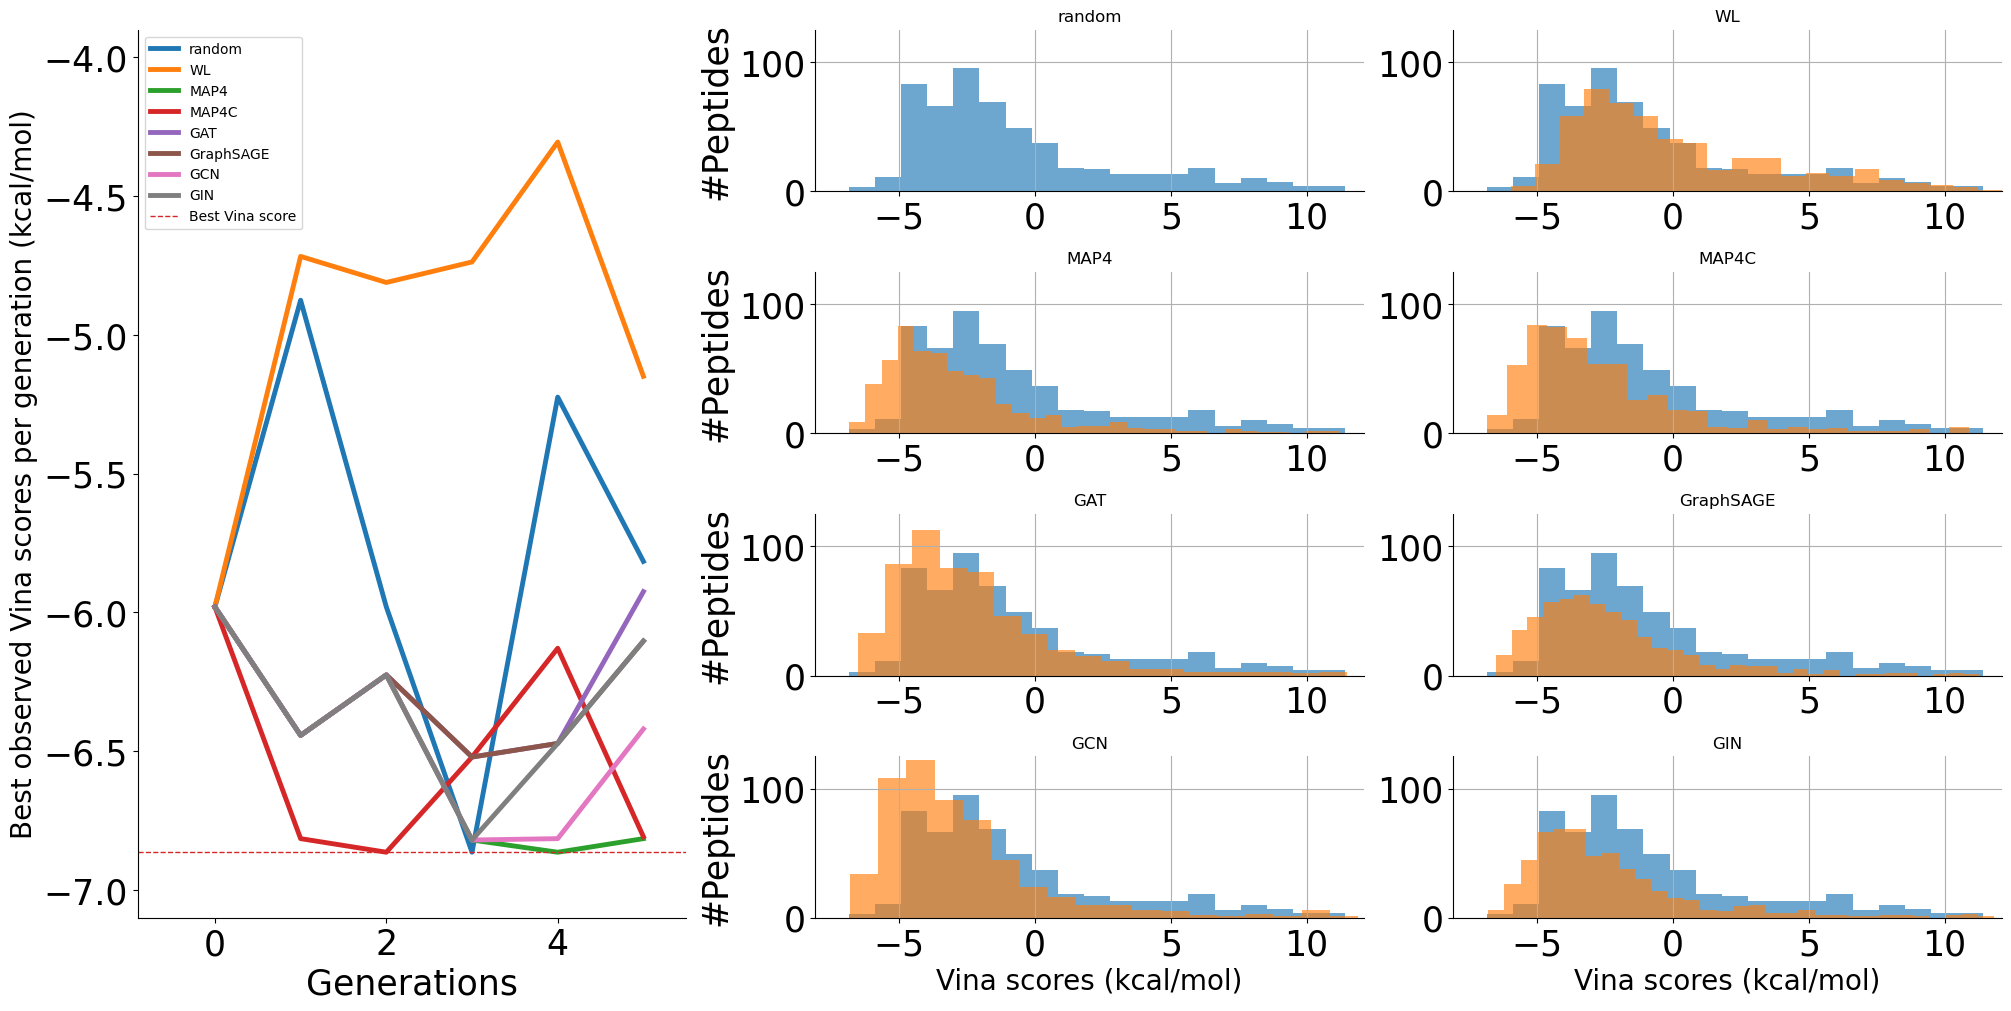

In [14]:
models = ['random', 'WL', 'MAP4', 'MAP4C', 'GAT', 'GraphSAGE', 'GCN', 'GIN']

dfs = []
dfs_min = []

for model in models:
    df = pd.read_csv(f'results_optimization_{model}_oracle.csv')
    df_min = df.loc[df.groupby(by=['iter'])['exp_value'].idxmin()]
    
    dfs.append(df)
    dfs_min.append(df_min)

df = pd.concat(dfs)
df_min = pd.concat(dfs_min)

axarr = plt.figure(figsize=(20, 10), layout="constrained").subplot_mosaic(
    """
    ABC
    ADE
    AFG
    AHI
    """
)

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df_min, ax=axarr['A'], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})
axarr['A'].hlines(-6.864, -0.9, 5.5, linestyles='--', linewidth=1, color='tab:red', label='Best Vina score')

axarr['A'].set_xlim([-0.9, 5.5])
axarr['A'].set_ylim([-7.1, -3.9])
axarr['A'].set_ylabel('Best observed Vina scores per generation (kcal/mol)', fontsize=20)
axarr['A'].set_xlabel('Generations', fontsize=25)
axarr['A'].xaxis.set_tick_params(labelsize=25)
axarr['A'].yaxis.set_tick_params(labelsize=25)
axarr['A'].legend(loc='upper left')

for ax, model in zip(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], models):
    df[df['model'] == 'random']['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=100)
    if model != 'random':
        df[df['model'] == model]['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=100)
    axarr[ax].set_xlim([-8.1, 12.1])
    axarr[ax].set_ylim([0, 125])
    axarr[ax].xaxis.set_tick_params(labelsize=25)
    axarr[ax].yaxis.set_tick_params(labelsize=25)
    axarr[ax].set_title(model)

axarr['H'].set_xlabel('Vina scores (kcal/mol)', fontsize=20)
axarr['I'].set_xlabel('Vina scores (kcal/mol)', fontsize=20)
axarr['B'].set_ylabel('#Peptides', fontsize=25)
axarr['D'].set_ylabel('#Peptides', fontsize=25)
axarr['F'].set_ylabel('#Peptides', fontsize=25)
axarr['H'].set_ylabel('#Peptides', fontsize=25)

sns.despine()

plt.savefig('figure_results_comparison_all_models.png', dpi=300, bbox_inches='tight')

plt.show()